In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from datetime import datetime, date

In [2]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0)

df = df_raw[['Date', 'Rainfall_Cavallina', 'Temperature_Le_Croci', 'Flow_Rate', 'Lake_Level']].copy()

df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
df.set_index(['Date'], inplace=True)
df = df.asfreq('D')
df = df.dropna()

df['Lake_Level'] -= (251 - 31)

df

,Rainfall_Cavallina,Temperature_Le_Croci,Flow_Rate,Lake_Level
Date,,,,
2004-01-02,0.0,6.50,0.5,31.21
2004-01-03,0.0,4.45,0.5,31.28
2004-01-04,0.0,2.00,0.5,31.35
2004-01-05,0.0,0.90,0.5,31.37
2004-01-06,0.0,2.25,0.5,31.42
...,...,...,...,...
2020-06-26,0.0,22.50,0.6,30.85
2020-06-27,0.0,23.40,0.6,30.84
2020-06-28,0.0,21.50,0.6,30.83


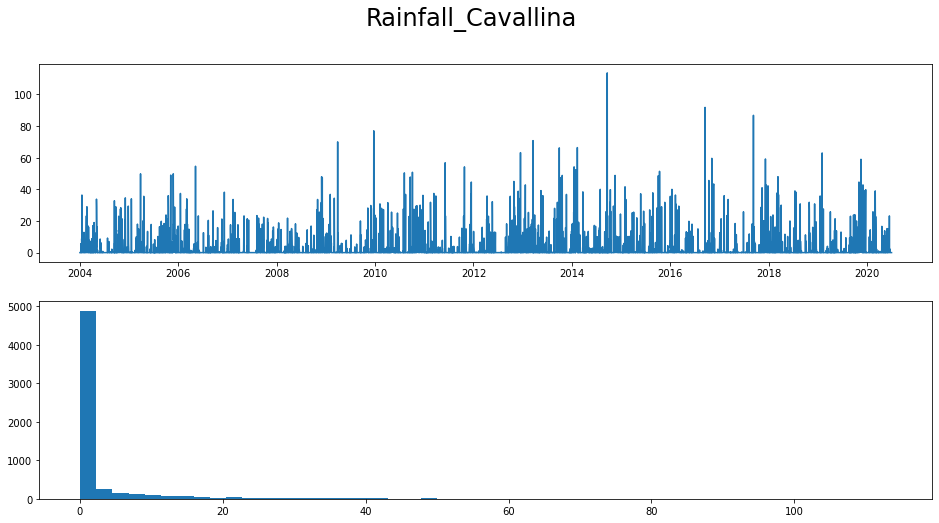

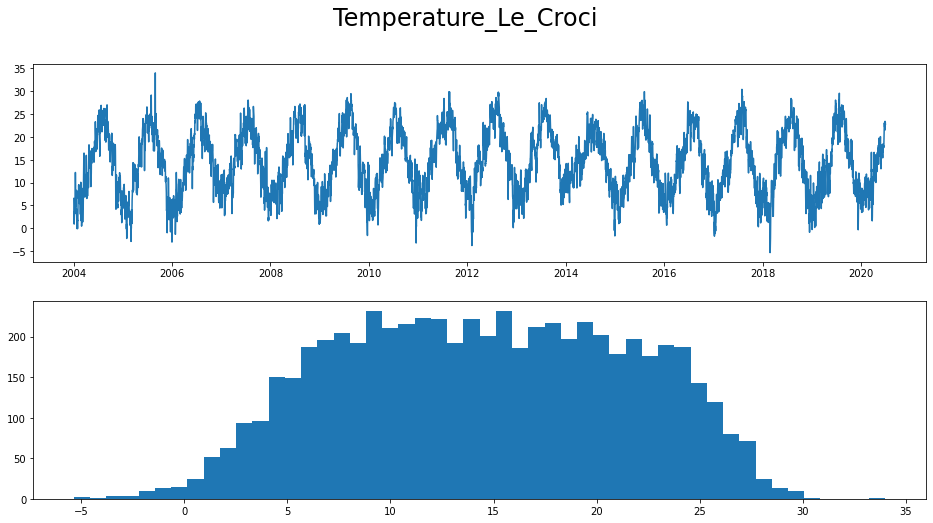

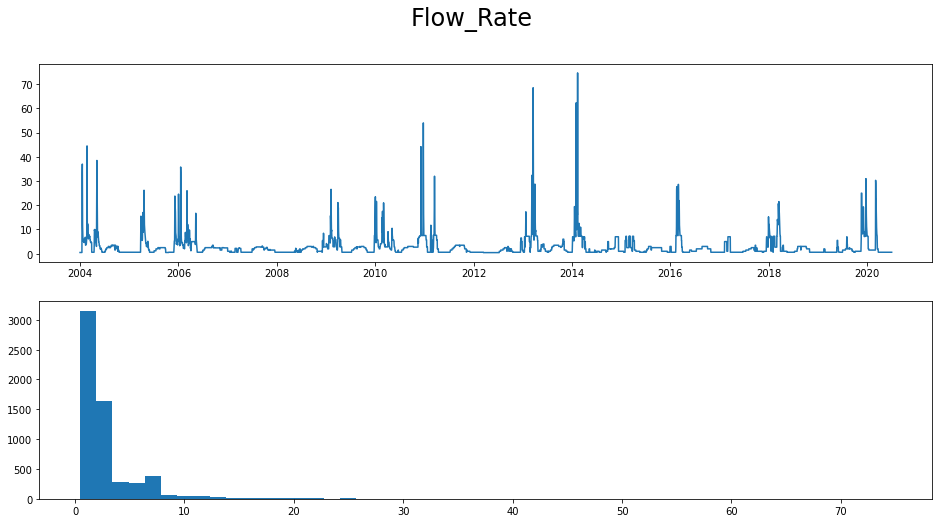

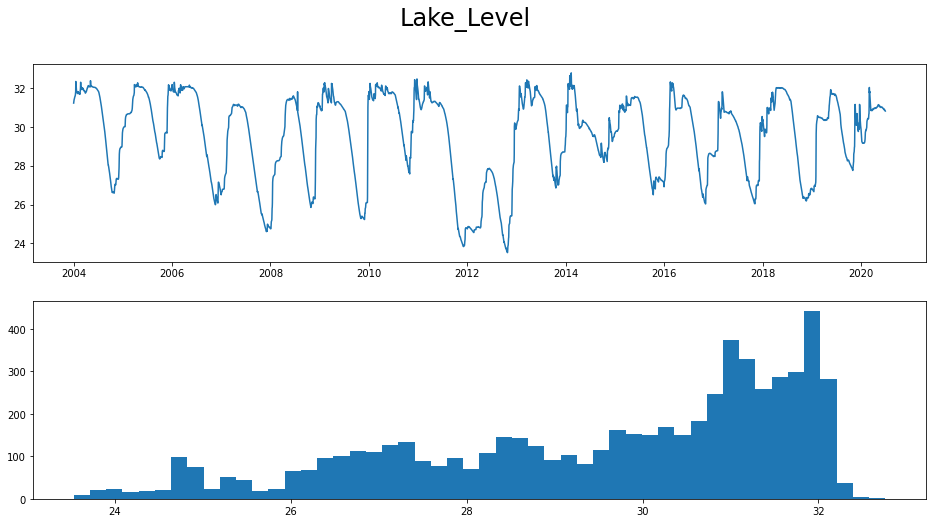

In [3]:
def visualise_column(df, column):
    fig, ax = plt.subplots(2,1, figsize=(16, 8))
    
    fig.suptitle(column, size=24)
    
    ax[0].plot(df[column])
    ax[1].hist(df[column], bins=50)
    

for c in df:
    visualise_column(df, c)

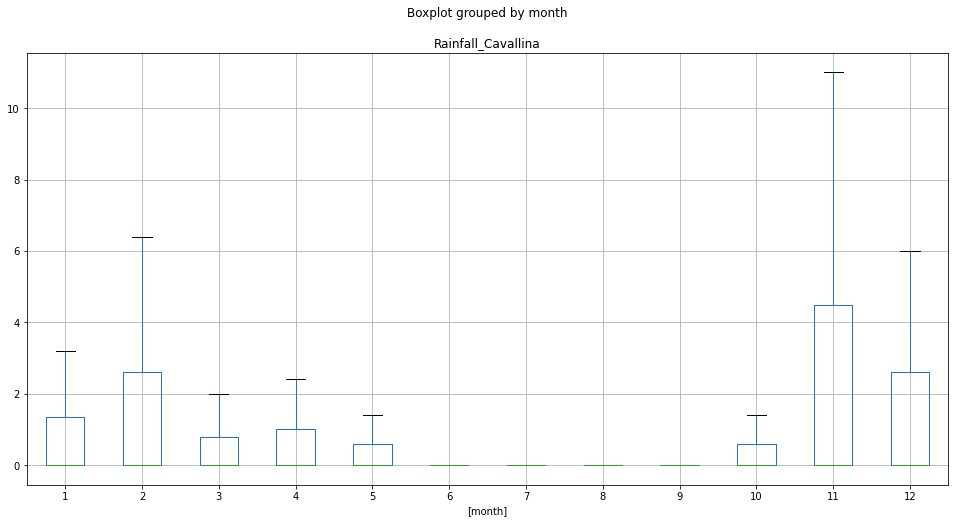

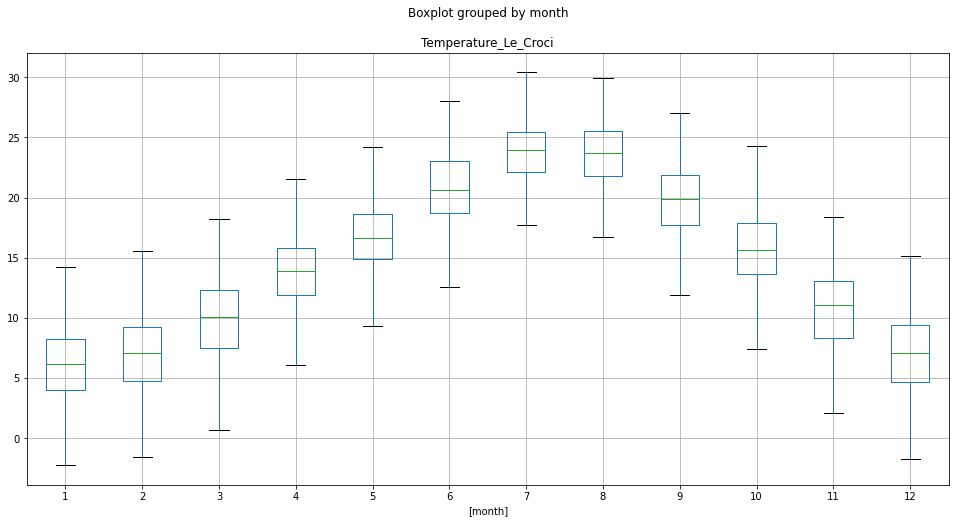

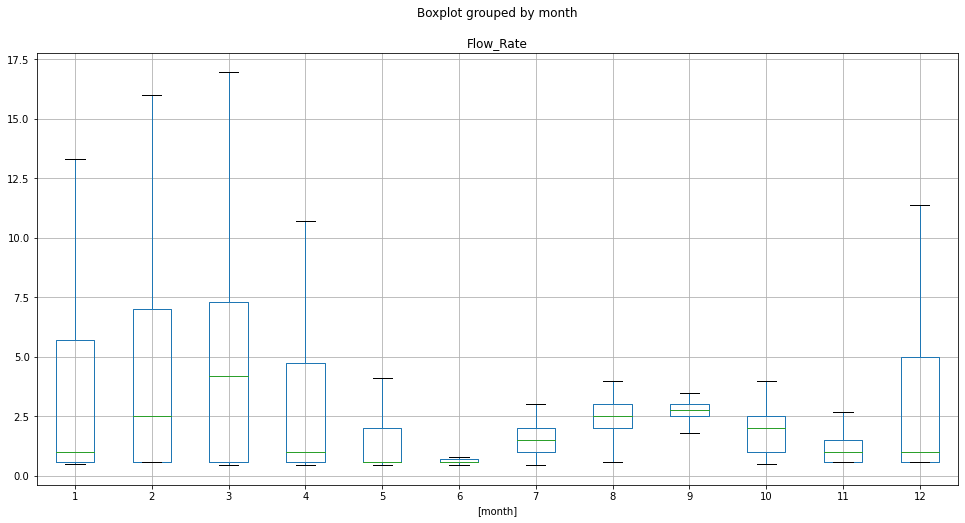

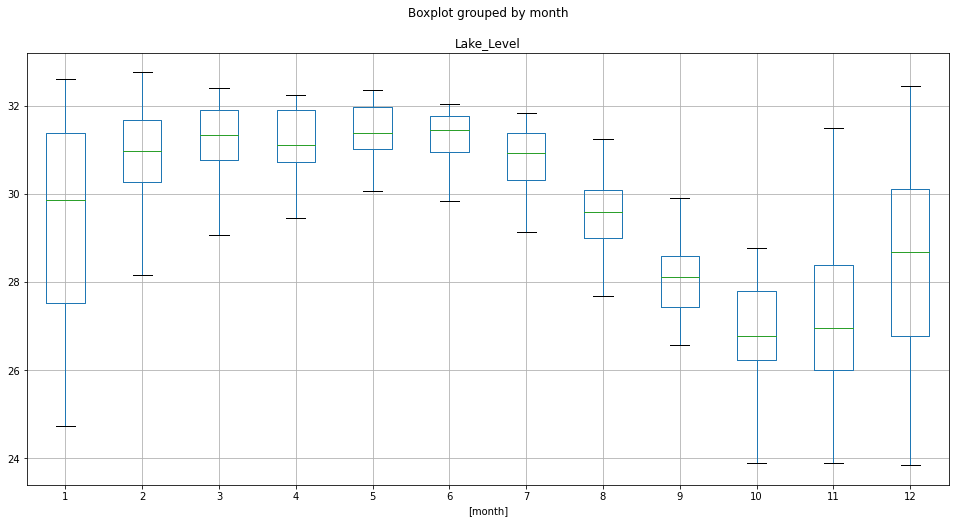

In [9]:
df['month'] = df.index.month

for c in df:
    if c not in ['month', 'month_sin', 'month_cos']:
        df[[c, 'month']].boxplot(by='month', figsize=(16,8), meanline=True, sym='');

del df['month'];

<AxesSubplot:xlabel='month_cos', ylabel='month_sin'>

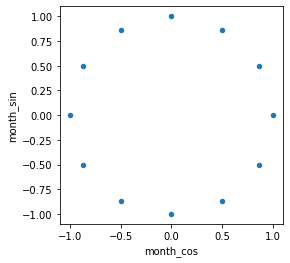

In [5]:
df['month_sin'] = np.sin((pd.to_datetime(df.index).month - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((pd.to_datetime(df.index).month - 1) * (2. * np.pi / 12))

df.groupby(['month_cos', 'month_sin']).size().reset_index().plot(x='month_cos', y='month_sin', kind='scatter', figsize=(4, 4))

,Rainfall_Cavallina,Temperature_Le_Croci,Flow_Rate,Lake_Level,month_sin,month_cos
Rainfall_Cavallina,1.000000,-0.128926,0.172770,-0.033917,-0.053140,0.123619
Temperature_Le_Croci,-0.128926,1.000000,-0.195136,0.063569,-0.105996,-0.884181
Flow_Rate,0.172770,-0.195136,1.000000,0.298833,0.087887,0.223395
Lake_Level,-0.033917,0.063569,0.298833,1.000000,0.648625,-0.172822
month_sin,-0.053140,-0.105996,0.087887,0.648625,1.000000,-0.004195
month_cos,0.123619,-0.884181,0.223395,-0.172822,-0.004195,1.000000


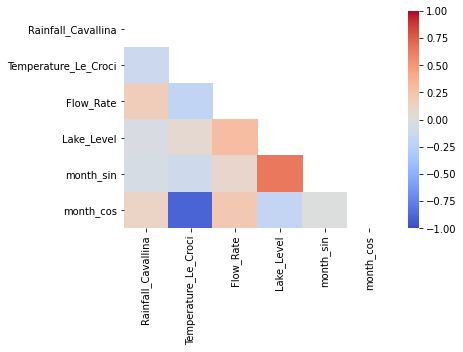

In [6]:
def correlation_matrix(df):
    corr = df.corr(method='pearson')
    sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1, cmap='coolwarm')
    return corr

correlation_matrix(df)

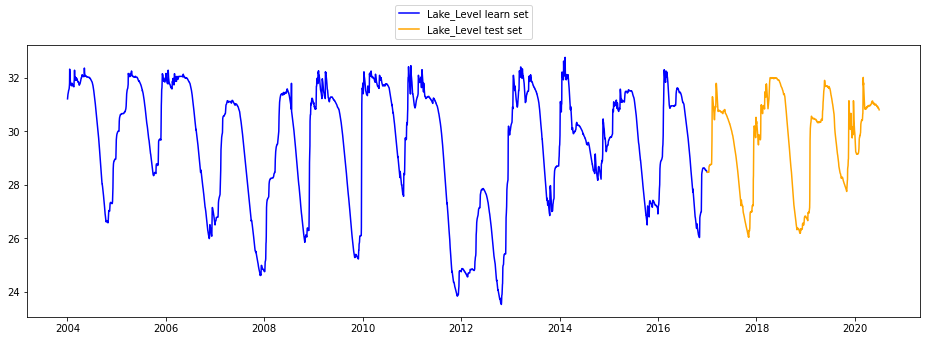

In [20]:
# Spliting data for models
split = df[df.index == pd.to_datetime('2017-01-01')].index[0]

d = df.dropna()
d = d.drop(['Flow_Rate'], axis=1) # Flow_Rate is another target variable

lrn = d.drop(['Lake_Level'], axis=1)
tgt = d['Lake_Level']

lrn_input = lrn[lrn.index < split]
lrn_output = tgt[tgt.index < split]

tgt_input = lrn[lrn.index >= split]
tgt_output = tgt[tgt.index >= split]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.plot(lrn_output, color='blue', label='Lake_Level learn set')
ax.plot(tgt_output, color='orange', label='Lake_Level test set')
fig.legend(loc='upper center');

def run_model(model, learn_input, learn_ouput, target_input, target_output):
    model.fit(learn_input, learn_ouput)
    return pd.DataFrame({ 'Predictions': model.predict(target_input), 'Lake_Level': target_output })

def evaluate_ae(result):
    result = result.dropna()
    print('   MAE: {}'.format(mean_absolute_error(result['Predictions'], result['Lake_Level'])))
    print('   RMAE: {}'.format(mean_squared_error(result['Predictions'], result['Lake_Level'])))

In [39]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(2)
# poly.fit_transform(lrn_output)

# svr_result = run_model(poly, lrn_input, lrn_output, tgt_input, tgt_output)
# evaluate_ae(svr_result)

# svr_result.plot(figsize=(16, 8))

Date
2004-01-02    31.21
2004-01-03    31.28
2004-01-04    31.35
2004-01-05    31.37
2004-01-06    31.42
              ...  
2016-12-27    28.52
2016-12-28    28.51
2016-12-29    28.50
2016-12-30    28.49
2016-12-31    28.48
Freq: D, Name: Lake_Level, Length: 4748, dtype: float64